# Overview
It's Feb 25th, 2015, and you need to book a flight to Ann Arbor for the Michigan vs. Ohio State basketball game. This is your first time flying, and you want to make it a good first experience. You know there are several airline choices out there, but you don't know who is the best and who is the worst. There's plenty of rating websites, but you can't always trust their sources. You want to hear from the people themselves. Who is the airline to avoid when flying? What are everyone's major complaints? The best source to hear people rant - **TWITTER!!!** Your task is to parse through twitter data from the week span of Feb 17th to Feb 24th, and figure out who has been the worst lately and why.

# Data & Setup
Utilize a twitter dataset that has been compiled for you to peform your analysis. Figure which airlines are being talked about and why. Not everyone goes on twitter complain, so be sure to sort out your negative tweets from all other ones so that you may perform your analysis on just the negative tweets. At the end, just for fun, let's see if the Twitter-verse has any true power. We will attempt to correlate an airlines twitter rating for the week to it's stock prices for the same time frame.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import seaborn as sns

# Skills & Concepts
The third cell of the notebook will not be shown to the learner, and lists the skills and concepts you are aiming to test with this question. Please remove all of the bullets from list below which you are *not* testing with this question. You can add new bullets with new skills wherever you see fit, and skills can focus on specific APIs or tools or more broadly on concepts related to the course. And don't worry if you're not sure, this is just a best guess list, there are usually many ways to solve a problem!
* python-dicts
* python-list comprehension
* python-lambda
* python-functions
* python-types
* python-strings
* python-csv
* python-dates and times
* python-objects
* python-map
* python-numpy
* python-pandas-Series
* python-pandas-Series-index
* python-pandas-Series-querying
* python-pandas-DataFrame
* python-pandas-DataFrame-read_csv
* python-pandas-DataFrame-querying
* python-pandas-DataFrame-indexing
* python-pandas-DataFrame-merge
* python-pandas-DataFrame-groupby
* python-pandas-DataFrame-agg
* python-pandas-Timestamp
* python-pandas-DateTime
* python-pandas-matplotlib
* python-regex
* python-fill_between




In [2]:
#Load and inspect data
df = pd.read_csv('Tweets.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
tweet_id                        14640 non-null int64
airline_sentiment               14640 non-null object
airline_sentiment_confidence    14640 non-null float64
negativereason                  9178 non-null object
negativereason_confidence       10522 non-null float64
airline                         14640 non-null object
airline_sentiment_gold          40 non-null object
name                            14640 non-null object
negativereason_gold             32 non-null object
retweet_count                   14640 non-null int64
text                            14640 non-null object
tweet_coord                     1019 non-null object
tweet_created                   14640 non-null object
tweet_location                  9907 non-null object
user_timezone                   9820 non-null object
dtypes: float64(2), int64(2), object(11)
memory usage: 1.7+ MB


We can see there's 14650 rows and 15 columns of data. There's a lot of missing data within some of these columns, but before we decide how to handle them. Let's first reduce the columns to the ones we might thing we are interested in. Let's print out a few lines of the dataframe and see what exactly is in each column.

In [3]:
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


There's a lot of information here, but some of it we don't need. Getting rid of some of these columns will also help out with our previous problem of what to do with the missing data. it appears that we might only be interested in:

#### ['airline_sentiment', 'airline_sentiment_confidence', 'negativereason', 'negativereason_confidence', 'name', 'text', 'tweet_coord', 'tweet_created', 'airline']

The naming of these columns are the greatest either. So let's reduce the dataframe to the columns of interest, and rename them at the same time and set the dates as the index.

In [120]:
def clean_df(df):
    df = df.loc[: , ['airline_sentiment', 
                         'airline_sentiment_confidence',
                         'negativereason',
                         'negativereason_confidence',              
                         'name',
                         'text',
                         'tweet_coord',
                         'tweet_created',
                         'airline']].rename(columns = {'airline_sentiment':'Rating',
                                                             'airline_sentiment_confidence':'Rating_Conf',
                                                             'negativereason':'Negative_Reason',
                                                             'negativereason_confidence':'Reason_Conf',
                                                             'name':'User',
                                                             'text':'Text',
                                                             'tweet_coord':'Coordinates',
                                                             'tweet_created':'Date'}).set_index('Date')
    return df
clean_df(df).head(10)

,Rating,Rating_Conf,Negative_Reason,Reason_Conf,User,Text,Coordinates,airline
Date,,,,,,,,
2015-02-24 11:35:52 -0800,neutral,1.0000,NaN,NaN,cairdin,@VirginAmerica What @dhepburn said.,NaN,Virgin America
2015-02-24 11:15:59 -0800,positive,0.3486,NaN,0.0000,jnardino,@VirginAmerica plus you've added commercials t...,NaN,Virgin America
2015-02-24 11:15:48 -0800,neutral,0.6837,NaN,NaN,yvonnalynn,@VirginAmerica I didn't today... Must mean I n...,NaN,Virgin America
2015-02-24 11:15:36 -0800,negative,1.0000,Bad Flight,0.7033,jnardino,@VirginAmerica it's really aggressive to blast...,NaN,Virgin America
2015-02-24 11:14:45 -0800,negative,1.0000,Can't Tell,1.0000,jnardino,@VirginAmerica and it's a really big bad thing...,NaN,Virgin America
2015-02-24 11:14:33 -0800,negative,1.0000,Can't Tell,0.6842,jnardino,@VirginAmerica seriously would pay $30 a fligh...,NaN,Virgin America
2015-02-24 11:13:57 -0800,positive,0.6745,NaN,0.0000,cjmcginnis,"@VirginAmerica yes, nearly every time I fly VX...",NaN,Virgin America
2015-02-24 11:12:29 -0800,neutral,0.6340,NaN,NaN,pilot,@VirginAmerica Really missed a prime opportuni...,NaN,Virgin America
2015-02-24 11:11:19 -0800,positive,0.6559,NaN,NaN,dhepburn,"@virginamerica Well, I didn't…but NOW I DO! :-D",NaN,Virgin America


Now that we have reduced our dataframe to it's desired form, we can now do some more investigating of our data. Whoever has compiled the data for us was nice enough to already extract the airlines from the tweet text and chronicle them for us in the "airline" column". Let's inspect the airlines and get a general sense of how keen the public is on them.

In [5]:
#Groupby airline, and reference the ratings column and then extract total count
print(clean_df(df).groupby('airline')['Rating'].count())


airline
American          2759
Delta             2222
Southwest         2420
US Airways        2913
United            3822
Virgin America     504
Name: Rating, dtype: int64


By grouping the data by airlines and indexing each of their ratings, we can see that there are 2759 tweets pertaining to american airlines, 2222 to delta, etc etc. But this doesn't give us full insight as to how many of each tweet is postive, neutral, or negative. Lets regroup our dataframe and extract the lower level details of each airlines ratings.

In [6]:
#groupby both airlines and rating and extract total count
print(clean_df(df).groupby(['airline','Rating']).count().iloc[:,0])

airline         Rating  
American        negative    1960
                neutral      463
                positive     336
Delta           negative     955
                neutral      723
                positive     544
Southwest       negative    1186
                neutral      664
                positive     570
US Airways      negative    2263
                neutral      381
                positive     269
United          negative    2633
                neutral      697
                positive     492
Virgin America  negative     181
                neutral      171
                positive     152
Name: Rating_Conf, dtype: int64


After applying the groupby method, we can see that there's quite a few people that aren't too happy with United airlines. But this layout is very messy and a little hard to read. Nothing tells a story quite like pictures do, so let's illustrate what is above

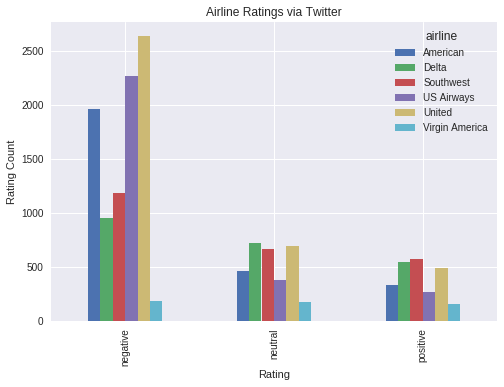

In [7]:
#create a graph by calling our clean_data function and then plots the total number of each tweet rating (positive,negative, or neutral)
ax = clean_df(df).groupby(['airline','Rating']).count().iloc[:,0].unstack(0).plot(kind = 'bar', title = 'Airline Ratings via Twitter')
ax.set_xlabel('Rating')
ax.set_ylabel('Rating Count')


plt.show()


So now that we painted the picture, it's very clear that United is indeed not a fan favorite. US Airways is a very close second. But this isn't normalizing the data. We can see to the far right over there, that Virgin America isn't really talked about all that much. So we need to correlate the number of negative tweets to the total number of tweets sent about a particular airline. What percentage of all tweets are negative for each airline.


            Percent Negative
American            0.710402
Delta               0.429793
Southwest           0.490083
US Airways          0.776862
United              0.688906
Virgin              0.359127


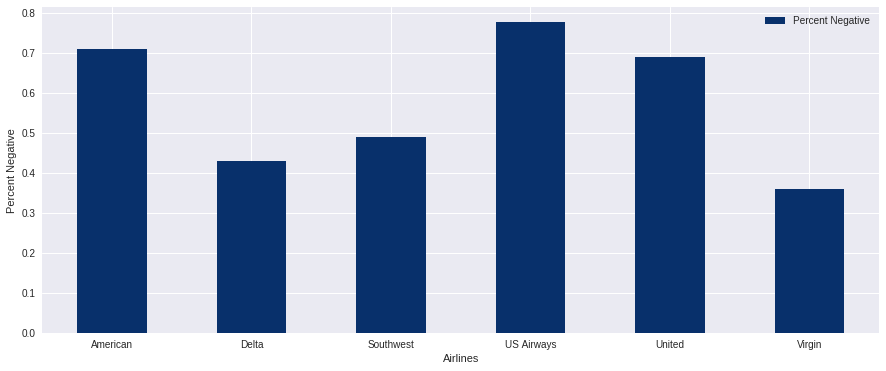

In [8]:
#Count of all tweet ratings for each airline (negative, neutral, positive)
itemized_tweets = clean_df(df).groupby(['airline','Rating']).count().iloc[:,0]
#Negative tweet total index for each airline:
#American 0
#Delta 3
#southwest 6
#US Airways 9
#United 12
#Virgin 15

#Count of total tweets about an airline
total_tweets = clean_df(df).groupby(['airline'])['Rating'].count()
#Airline index in total tweets:
#American 0
#Delta 1
#Southwest 2
#US Airways 3
#United 4
#Virgin 5


#Create a dictionary of percentage of negative tweets = (negative_tweets / total_tweets)
my_dict = {'American':itemized_tweets[0] / total_tweets[0],
           'Delta':itemized_tweets[3] / total_tweets[1],
           'Southwest': itemized_tweets[6] / total_tweets[2],
           'US Airways': itemized_tweets[9] / total_tweets[3],
           'United': itemized_tweets[12] / total_tweets[4],
           'Virgin': itemized_tweets[15] / total_tweets[5]}

#make a dataframe from the dictionary
perc_negative = pd.DataFrame.from_dict(my_dict, orient = 'index')
#have to manually set column name when using .from_dict() method
perc_negative.columns = ['Percent Negative']
print(perc_negative)
ax = perc_negative.plot(kind = 'bar', rot=0, colormap = 'Blues_r', figsize = (15,6))
ax.set_xlabel('Airlines')
ax.set_ylabel('Percent Negative')
plt.show()


This levels the playing field a little bit, and here we can see that even though United had the most negative tweets by far, they still only made up only 68% of all their tweets. Whereas US Airways and American had higher percentages at 77 and 71 percent respectively. This means that they might not be talking about American or US Airways as much as United, but when they are, it's mostly negative. Lets see what percentage makes up the positive tweets for each airline

            Percent Positive
American            0.121783
Delta               0.244824
Southwest           0.235537
US Airways          0.092345
United              0.128728
Virgin              0.301587


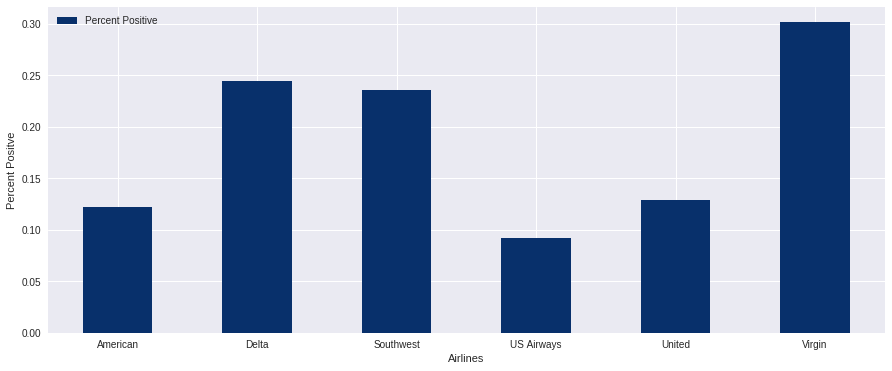

In [9]:
itemized_tweets = clean_df(df).groupby(['airline','Rating']).count().iloc[:,0]
#Positve tweet total index for each airline:
#American 2
#Delta 5
#southwest 8
#US Airways 11
#United 14
#Virgin 17

total_tweets = clean_df(df).groupby(['airline'])['Rating'].count()
#Airline index in total tweets:
#American 0
#Delta 1
#Southwest 2
#US Airways 3
#United 4
#Virgin 5


#Create a dictionary of percentage of positive tweets = (positive_tweets / total_tweets)
my_dict = {'American':itemized_tweets[2] / total_tweets[0],
           'Delta':itemized_tweets[5] / total_tweets[1],
           'Southwest': itemized_tweets[8] / total_tweets[2],
           'US Airways': itemized_tweets[11] / total_tweets[3],
           'United': itemized_tweets[14] / total_tweets[4],
           'Virgin': itemized_tweets[17] / total_tweets[5]}

#make a dataframe from the dictionary
perc_positive = pd.DataFrame.from_dict(my_dict, orient = 'index')
#have to manually set column name when using .from_dict() method
perc_positive.columns = ['Percent Positive']
print(perc_positive)
ax = perc_positive.plot(kind = 'bar', rot=0, colormap = 'Blues_r', figsize = (15,6))
ax.set_xlabel('Airlines')
ax.set_ylabel('Percent Positve')
plt.show()


Oh US Airways, it started off looking like United was going to win crown of "Worst Airlines". But with only 9% positive tweets, it's more and more starting to look like I shouldn't fly with you. Obviously the last metric would be graphing out the neutral tweets, but that doesn't tell us a whole lot. Let's put all 3 categories together and paint one single picture instead of 3 seperate pages.

In [10]:
#create a function that will concatenate our perc_negative, perc_neutral and perc_positive dataframes into one single dataframe
def merge_dfs(x,y,z):
    #generate a list of the dataframes
    list_of_dfs = [x,y,z]
    #concatenate the dataframes, axis = 1 because they all have the same index, we just want to add the columns together
    concatenated_dataframe = pd.concat(list_of_dfs, axis = 1)
    return concatenated_dataframe

We created a function that will concatnenate our previous dictionaries of percentages. Now we must create another dictionary of the percentages of neutral tweets, and then combine them all together.

            Percent Neutral  Percent Negative  Percent Positive
American           0.167814          0.710402          0.121783
Delta              0.325383          0.429793          0.244824
Southwest          0.274380          0.490083          0.235537
US Airways         0.130793          0.776862          0.092345
United             0.182365          0.688906          0.128728
Virgin             0.339286          0.359127          0.301587


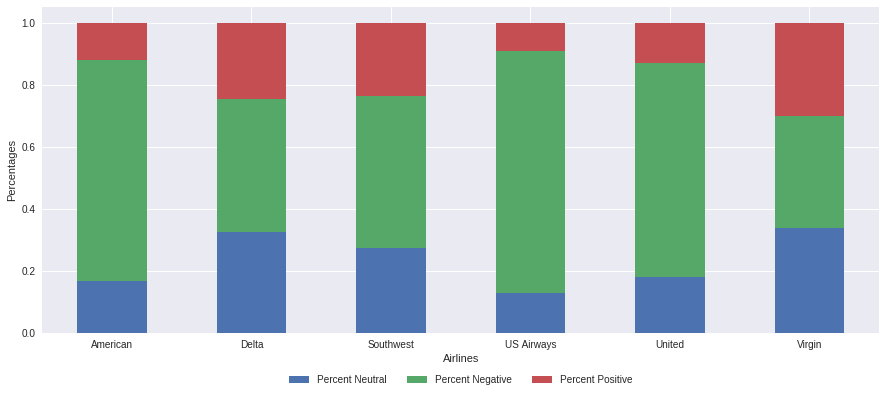

In [11]:
itemized_tweets = clean_df(df).groupby(['airline','Rating']).count().iloc[:,0]
#Netural tweet total index for each airline:
#American 1
#Delta 4
#southwest 7
#US Airways 10
#United 13
#Virgin 16

total_tweets = clean_df(df).groupby(['airline'])['Rating'].count()
#Airline index in total tweets:
#American 0
#Delta 1
#Southwest 2
#US Airways 3
#United 4
#Virgin 5


#Create a dictionary of percentage of positive tweets = (positive_tweets / total_tweets)
my_dict = {'American':itemized_tweets[1] / total_tweets[0],
           'Delta':itemized_tweets[4] / total_tweets[1],
           'Southwest': itemized_tweets[7] / total_tweets[2],
           'US Airways': itemized_tweets[10] / total_tweets[3],
           'United': itemized_tweets[13] / total_tweets[4],
           'Virgin': itemized_tweets[16] / total_tweets[5]}

#make a dataframe from the dictionary
perc_neutral = pd.DataFrame.from_dict(my_dict, orient = 'index')
#Have to manually set column name
perc_neutral.columns = ['Percent Neutral']

#call our function to concatenate all 3 dataframes of percentages
percentage = merge_dfs(perc_neutral, perc_negative, perc_positive)
print(percentage)

#graph all of our data
ax = percentage.plot(kind = 'bar', stacked = True, rot = 0, figsize = (15,6))
#set x label
ax.set_xlabel('Airlines')
#set y label
ax.set_ylabel('Percentages')
#move the legend to the bottom of the graph since it wants to sit over all of our data and block it - stupid legend
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),
          fancybox=True, shadow=True, ncol=5)

plt.show()

So we just did a good bit of analysis on our data, but we got so focused on what we've been working on, that we got sidetracked from inspecting all of our data. From initial analysis, it's looking like United made a lot of people unhappy. However we took advantage of one particular caveat. We assumed that whomever compiled all the data for us, correctly identified the airline being referenced in the tweet text. I purposely carried on like this because this **ACTUALLY HAPPENED TO ME!** And it highlights some headaches you will come across when dealing with realworld messy data. Lets look at some of the tweet text and compare it to the airline being referenced

In [12]:
observation = list(clean_df(df).reset_index().iloc[6750:6755,8])
tweet_text = list(clean_df(df).reset_index().iloc[6750:6755,6])

for pos, item in enumerate(observation):
    print('Airline as compiled: ' + str(item))
    print('The actual tweet text: ')
    print(tweet_text[pos], '\n''\n')

Airline as compiled: Delta
The actual tweet text: 
@JetBlue everyone is here but our pilots are no where to be found and my last flight the plane was dirty that I had to clean my area &amp; seat! 


Airline as compiled: Delta
The actual tweet text: 
@JetBlue update on Flight 462 would be appreciated when you have time, thanks 


Airline as compiled: Delta
The actual tweet text: 
@JetBlue check DM please :) 


Airline as compiled: Delta
The actual tweet text: 
@JetBlue Hey guys, why did my last flight earn me 0 pts? http://t.co/1syWlmTZek 


Airline as compiled: Delta
The actual tweet text: 
@JetBlue 2 aisles of empty #evermoreroom seats and we can't move bc we didn't pay?! #nonsense #Waste #JetBlue #jetbluebos #cheap 




### Well crap!!! 
We did all that work, and the data in the table was incorrect. As we can see in those particular locations, Delta was tagged as the Airline being referenced in the tweet. But when we look at the actual text we can see it was really Jet Blue being referenced. This actually happened to me when dealing with the data the first time. We now must get rid of the 'Airline' column in the dataframe, parse all the tweet text and pullout the proper airline being referenced in all Tweets. Sure, whoever compiled this probably didn't get **All** of them wrong, but do you really want to scroll through 14k+ lines of data to check. Let's just make some code that parses through for us.

In [13]:
#let's start by getting rid of the current 'Airline' column
#'Airline' was the last column (8) so we just sliced the dataframe, stopping at column (7) 'Coordinates'
new_df = clean_df(df).iloc[:,0:7]
new_df.head()

,Rating,Rating_Conf,Negative_Reason,Reason_Conf,User,Text,Coordinates
Date,,,,,,,
2015-02-24 11:35:52 -0800,neutral,1.0000,NaN,NaN,cairdin,@VirginAmerica What @dhepburn said.,NaN
2015-02-24 11:15:59 -0800,positive,0.3486,NaN,0.0000,jnardino,@VirginAmerica plus you've added commercials t...,NaN
2015-02-24 11:15:48 -0800,neutral,0.6837,NaN,NaN,yvonnalynn,@VirginAmerica I didn't today... Must mean I n...,NaN
2015-02-24 11:15:36 -0800,negative,1.0000,Bad Flight,0.7033,jnardino,@VirginAmerica it's really aggressive to blast...,NaN
2015-02-24 11:14:45 -0800,negative,1.0000,Can't Tell,1.0000,jnardino,@VirginAmerica and it's a really big bad thing...,NaN


We now need to extract the right airline from the tweet text. Examining it, we can see that all airlines references are preceded by an '@' symbol. We all know this is a common twitter tag, so by looking for this, we can extract the airline being talked about. Be wary though, some of the texts can have more than just the airline tagged in it. But this is where we will start, using a regular expression that will find all instances of the '@' symbol. Looking at the majority of the tweet text, the airline is usually the first '@' tag in the text in the event their are multiple. So we will make the general assumption that during our regular expression search, when there are multiple '@' tags, the airline will be the first one. 

In [14]:
#first, create a new column called 'Airline'
#Then reference the 'text' column to apply your regular expression function to
#apply a lambda function that parses through each tweet text and searches for '@' symbol followed by any letter type
#extract the first matched instance [0] in the event there are multiple
new_df['Airline'] = new_df.Text.apply(lambda x: re.findall('\@[A-Za-z]+', x)[0])

#check that our regular expression is working
list(new_df.Airline.head(10))

['@VirginAmerica',
 '@VirginAmerica',
 '@VirginAmerica',
 '@VirginAmerica',
 '@VirginAmerica',
 '@VirginAmerica',
 '@VirginAmerica',
 '@VirginAmerica',
 '@virginamerica',
 '@VirginAmerica']

Ok, so with 14k+ lines of data, there's no telling what all our regular expression function found. So to help figure this out, lets list all the unique items it found. From this, we can see all the airlines it extracted, plus any other tag that was referenced first in a tweet text before the airline tag.

In [15]:
#get all unique twitter tags and the count for how many times it appears in the column
twitter_tags = np.unique(new_df.Airline, return_counts = True)

#compile twitter_tags so that it lists the unique tag and its total count side by side instead of 2 seperate arrays
twitter_tags_count = list(zip(twitter_tags[0],twitter_tags[1]))
twitter_tags_count

[('@AlbertBreer', 1),
 ('@AmericanAir', 2722),
 ('@AndrewFallis', 1),
 ('@CatfoodBeerGlue', 1),
 ('@DadBoner', 1),
 ('@DeltaAssist', 2),
 ('@HillAConlin', 1),
 ('@Imaginedragons', 1),
 ('@InternJohnRadio', 1),
 ('@JetBlue', 2167),
 ('@Jetblue', 4),
 ('@KCIAirport', 1),
 ('@MandarinJourney', 1),
 ('@MelissaAFrancis', 1),
 ('@NinaDavuluri', 1),
 ('@Sb', 1),
 ('@SouthwestAir', 2370),
 ('@Southwestair', 2),
 ('@USAIRWAYS', 1),
 ('@USAirways', 2817),
 ('@USairways', 2),
 ('@United', 122),
 ('@UsAirways', 2),
 ('@Usairways', 2),
 ('@VirginAmerica', 486),
 ('@americanair', 32),
 ('@chasefoster', 1),
 ('@djevolutionhd', 1),
 ('@eatgregeat', 1),
 ('@jetblue', 44),
 ('@lindaSWC', 1),
 ('@malhoit', 1),
 ('@nrhodes', 2),
 ('@nytimes', 1),
 ('@ods', 1),
 ('@sarahpompei', 1),
 ('@scm', 1),
 ('@shannonwoodward', 1),
 ('@southwestAir', 1),
 ('@southwestair', 44),
 ('@timbennettg', 1),
 ('@united', 3695),
 ('@usairways', 81),
 ('@vanessaannz', 1),
 ('@virginAmerica', 1),
 ('@virginamerica', 17)]

So our assumption that the airline is referenced before any other tag was a pretty good guess. We did return some other users twitter names, but for the most part, we got all airline references. We can also see that Jet blue was reference **Alot**. In our original dataframe, there was no mention of Jet Blue. Next, we need to go through the unique list and compile all the airlines referenced into a list. Notice that the airlines are referenced multiple times, this is because they are camel case. When searching for "unique" items, @virginAmerica is different than @virginamerica due to the one capital letter. So we need to refine our regular expression search, looking not only for the airlines, but ignoring the camel case so that all spellings of an airline are equal

In [16]:
#List of all airlines in the data as found from the tweets in search above
airline_list = ['@virginamerica','@united','@southwestair','@americanair','@jetblue','@usairways']
    
#compile a regex search to seperate out only the airline tag and ignoring other users tags in the text
#using the compile method is an easier way to input our "match" pattern into the search engine, especially in this event
#when we are searching for mulitple airlines.
#we are ignoring case, or capitaliztion  in order to negate all the uniquess we encountered in the list above
airlines = re.compile('|'.join(airline_list), re.IGNORECASE)
    
#apply the compiled regex search and remove the twitter tag '@'
#for example, the following code takes @AmericanAir and returns AmericanAir
new_df['Airline'] = new_df.Airline.apply(lambda x: np.squeeze(re.findall(airlines, x))).str.split('@').str[1]
print(list(new_df.Airline.head(10)))

['VirginAmerica', 'VirginAmerica', 'VirginAmerica', 'VirginAmerica', 'VirginAmerica', 'VirginAmerica', 'VirginAmerica', 'VirginAmerica', 'virginamerica', 'VirginAmerica']


Great, so now we have found only the airlines, and removed the '@' tag from them. But what happened to the rows where the airline didn't come first and we extracted a users name instead? Well by default, they were filled in with NaN since they didn't match anything in the matching patter. The code below uses boolean logic to filter the data frame and find the index locations of those tweets, and displays all '@' tags that was referenced in the tweet text. This step is needed so we could find those locations that did not have an airline in place, and manually set the values for these locations in the dataframe

In [17]:
no_airline = new_df.reset_index()
no_airline = no_airline[no_airline.Airline.isnull()].Text.apply(lambda x: re.findall('\@[A-Za-z]+', x))
no_airline

737                              [@lindaSWC, @united]
868                       [@MandarinJourney, @united]
1088                      [@MelissaAFrancis, @United]
4013                             [@DadBoner, @united]
4604                 [@Imaginedragons, @SouthwestAir]
5614                     [@KCIAirport, @SouthwestAir]
6136     [@InternJohnRadio, @mrerickv, @SouthwestAir]
6362                    [@HillAConlin, @SouthwestAir]
6796                     [@CatfoodBeerGlue, @JetBlue]
6811                          [@eatgregeat, @JetBlue]
6906                             [@nytimes, @JetBlue]
7330                               [@shannonwoodward]
8215                                  [@NinaDavuluri]
10243                               [@Sb, @USAirways]
10517                      [@timbennettg, @USAirways]
10799                          [@nrhodes, @USAirways]
10864                      [@sarahpompei, @USAirways]
10874                     [@AndrewFallis, @USAirways]
10876                       

Great, so now we can see where the null values are located because the first '@' tag is a user's name, and what airline was supposed to be referenced. Now we can manually set these, and then our 'Airline' column will be up to date and correct. One little issue here, indices 7330 and  8215 didn't have any '@' tag with an airline next to it, so we are just going to have to read the tweet text manually and extract that for ourselves. But don't worry, I did that for you already =) 

In [18]:
#reset the index of our dataframe
new_df = new_df.reset_index()

#compile a list of index locations of the tweets that return null and set their airline value to the appropriate
#airline referenced in the tweet
united = [737,868,1088,4013]
southwest = [4604,5614,5615,6136,6362]
jetblue = [6796,6811,6906]
usairways = [7330, 8215,10243,10517,10799,10864,10874,10876,11430]
american = [11159,12222,12417,12585,13491,13979]
delta = [12038, 12039]
new_df.set_value(united,'Airline','united')
new_df.set_value(southwest,'Airline','southwestair')
new_df.set_value(jetblue,'Airline','jetblue')
new_df.set_value(usairways,'Airline','usairways')
new_df.set_value(american,'Airline','americanair')
new_df.set_value(delta,'Airline','delta')
    
#Since all airlines tweets are camel case in different orders, make all airlines uppercase so they are all equal
new_df.Airline = new_df.Airline.apply(lambda x: x.upper())
    
#create a dictionary to map the all uppercase airlines to the proper naming convention
map_airline = {'AMERICANAIR':'American Airlines',
                'JETBLUE':'Jet Blue',
                'SOUTHWESTAIR':'Southwest Airlines',
                'UNITED': 'United Airlines',
                'USAIRWAYS': 'US Airways',
                'VIRGINAMERICA':'Virgin Airlines',
                'DELTA':'Delta Airlines'}
    
#map the uppercase airlines to the proper naming convention
new_df.Airline = new_df.Airline.map(map_airline)

#display our new airlines!!!
np.unique(new_df.Airline)

array(['American Airlines', 'Delta Airlines', 'Jet Blue',
       'Southwest Airlines', 'US Airways', 'United Airlines',
       'Virgin Airlines'], dtype=object)

Next order of busines - Continuing to inspect our data before continuing on with any analysis! We don't need another headache. When trying to display truthful data, we need to decide which data is truthful. When deciding what to rate the tweet text, the compiler also added a column "Rating Confidence". This is a percentage of how sure they are that the rating the gave was the proper rating. Let's inspect some of these

In [123]:
rating = list(new_df.Rating)
conf = list(new_df.Rating_Conf)
text = list(new_df.Text)

for i in range(10):
    print(rating[i], '\n', conf[i], '\n', text[i],'\n','\n')
    
    

neutral 
 1.0 
 @VirginAmerica What @dhepburn said. 
 

positive 
 0.3486 
 @VirginAmerica plus you've added commercials to the experience... tacky. 
 

neutral 
 0.6837 
 @VirginAmerica I didn't today... Must mean I need to take another trip! 
 

negative 
 1.0 
 @VirginAmerica it's really aggressive to blast obnoxious "entertainment" in your guests' faces &amp; they have little recourse 
 

negative 
 1.0 
 @VirginAmerica and it's a really big bad thing about it 
 

negative 
 1.0 
 @VirginAmerica seriously would pay $30 a flight for seats that didn't have this playing.
it's really the only bad thing about flying VA 
 

positive 
 0.6745 
 @VirginAmerica yes, nearly every time I fly VX this “ear worm” won’t go away :) 
 

neutral 
 0.634 
 @VirginAmerica Really missed a prime opportunity for Men Without Hats parody, there. https://t.co/mWpG7grEZP 
 

positive 
 0.6559 
 @virginamerica Well, I didn't…but NOW I DO! :-D 
 

positive 
 1.0 
 @VirginAmerica it was amazing, and arrived an 

Looking at few of the ratings and the corresponding text, it's pretty reasonable to say the rating and it's corresponding confidence percentage is more or less in the ballpark. Armed with this data, let's now make our data even more accurate. There are ratings given to an airline that the confidence is pretty low. Since we don't want to mislabel the airline, we are probably better suited to only analyze the data in which were are pretty sure that the rating is the correct one. This part is basically at the discretion of the user, but to me, 51% is winning. So let's filter our data down to those ratings that have only greater than 0.51 rating confidence percentages.

In [20]:
#we could make this one line, but i'm breaking it up for readability
#set our boolean variable so that it filters the dataframe for only instances where the rating conf is >0.51


conf_df = new_df[new_df.Rating_Conf >= 0.51 ]
print(conf_df.info())
conf_df.head(10)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14403 entries, 0 to 14639
Data columns (total 9 columns):
Date               14403 non-null object
Rating             14403 non-null object
Rating_Conf        14403 non-null float64
Negative_Reason    9114 non-null object
Reason_Conf        10285 non-null float64
User               14403 non-null object
Text               14403 non-null object
Coordinates        1009 non-null object
Airline            14403 non-null object
dtypes: float64(2), object(7)
memory usage: 1.1+ MB
None


,Date,Rating,Rating_Conf,Negative_Reason,Reason_Conf,User,Text,Coordinates,Airline
0,2015-02-24 11:35:52 -0800,neutral,1.0000,NaN,NaN,cairdin,@VirginAmerica What @dhepburn said.,NaN,Virgin Airlines
2,2015-02-24 11:15:48 -0800,neutral,0.6837,NaN,NaN,yvonnalynn,@VirginAmerica I didn't today... Must mean I n...,NaN,Virgin Airlines
3,2015-02-24 11:15:36 -0800,negative,1.0000,Bad Flight,0.7033,jnardino,@VirginAmerica it's really aggressive to blast...,NaN,Virgin Airlines
4,2015-02-24 11:14:45 -0800,negative,1.0000,Can't Tell,1.0000,jnardino,@VirginAmerica and it's a really big bad thing...,NaN,Virgin Airlines
5,2015-02-24 11:14:33 -0800,negative,1.0000,Can't Tell,0.6842,jnardino,@VirginAmerica seriously would pay $30 a fligh...,NaN,Virgin Airlines
6,2015-02-24 11:13:57 -0800,positive,0.6745,NaN,0.0000,cjmcginnis,"@VirginAmerica yes, nearly every time I fly VX...",NaN,Virgin Airlines
7,2015-02-24 11:12:29 -0800,neutral,0.6340,NaN,NaN,pilot,@VirginAmerica Really missed a prime opportuni...,NaN,Virgin Airlines
8,2015-02-24 11:11:19 -0800,positive,0.6559,NaN,NaN,dhepburn,"@virginamerica Well, I didn't…but NOW I DO! :-D",NaN,Virgin Airlines
9,2015-02-24 10:53:27 -0800,positive,1.0000,NaN,NaN,YupitsTate,"@VirginAmerica it was amazing, and arrived an ...",NaN,Virgin Airlines
10,2015-02-24 10:48:24 -0800,neutral,0.6769,NaN,0.0000,idk_but_youtube,@VirginAmerica did you know that suicide is th...,NaN,Virgin Airlines


So surprisingly, improving our confidence statistics only reduced our data by some 200+ rows. Whoever compiled the data was pretty sure of themselves. Now, one final thing, the index is set as the date and time, but we don't realy like that format. I don't think there's much value in having it as low as the hours minutes and seconds. So let's convert this to just month day and year. Also, although not shown, the type of the date time in the index is **'string'**. When dealing with pandas, it's better to have the 'type' as pandas **'datetime'**. So let's convert as well

In [21]:
#create a copy of our original dataframe and reset the index
date = conf_df.reset_index()
#convert the Date column to pandas datetime
date.Date = pd.to_datetime(date.Date)
#Reduce the dates in the date column to only the date and no time stamp using the 'dt.date' method
date.Date = date.Date.dt.date
date.Date.head()


0    2015-02-24
1    2015-02-24
2    2015-02-24
3    2015-02-24
4    2015-02-24
Name: Date, dtype: object

In [22]:
conf_df = date
conf_df.head()

,index,Date,Rating,Rating_Conf,Negative_Reason,Reason_Conf,User,Text,Coordinates,Airline
0,0,2015-02-24,neutral,1.0000,NaN,NaN,cairdin,@VirginAmerica What @dhepburn said.,NaN,Virgin Airlines
1,2,2015-02-24,neutral,0.6837,NaN,NaN,yvonnalynn,@VirginAmerica I didn't today... Must mean I n...,NaN,Virgin Airlines
2,3,2015-02-24,negative,1.0000,Bad Flight,0.7033,jnardino,@VirginAmerica it's really aggressive to blast...,NaN,Virgin Airlines
3,4,2015-02-24,negative,1.0000,Can't Tell,1.0000,jnardino,@VirginAmerica and it's a really big bad thing...,NaN,Virgin Airlines
4,5,2015-02-24,negative,1.0000,Can't Tell,0.6842,jnardino,@VirginAmerica seriously would pay $30 a fligh...,NaN,Virgin Airlines


Ok, now we have our data looking much better, let's rerun the analysis we originally did and plot the results..... **AGAIN**

In [23]:
test = conf_df[conf_df.Airline != 'Delta Airlines'].groupby(['Airline','Rating']).count().iloc[:,0]
test

Airline             Rating  
American Airlines   negative    1955
                    neutral      448
                    positive     330
Jet Blue            negative     936
                    neutral      699
                    positive     530
Southwest Airlines  negative    1177
                    neutral      641
                    positive     555
US Airways          negative    2253
                    neutral      367
                    positive     257
United Airlines     negative    2612
                    neutral      675
                    positive     472
Virgin Airlines     negative     179
                    neutral      167
                    positive     148
Name: index, dtype: int64

We need to create the seperate dataframes again for the percentage: positive, negative, and neutral. But instead of rewriting all the repeating code 3 times again, let's just write one function that we can pass the rating type we want to compile and let it do all the work for us for each rating.

In [24]:
def percentages(df, rating = 'negative'):
    if rating == 'negative':
        i = 0
        column = 'Percent Negative'
    elif rating == 'neutral':
        i = 1
        column = 'Percent Neutral'
    elif rating == 'positive':
        i = 2
        column = 'Percent Positive'
        
    #Count of all tweet ratings for each airline (negative, neutral, positive), remove Delta since it only has 2 entries total
    itemized_tweets = df[df.Airline != 'Delta Airlines'].groupby(['Airline','Rating']).count().iloc[:,0]
    #Rating tweet total index for each airline:
    #American i
    #Jet Blue i + 3
    #southwest i + 6
    #US Airways i + 9
    #United i + 12
    #Virgin i + 15

    #Count of total tweets about an airline
    total_tweets = df[df.Airline != 'Delta Airlines'].groupby(['Airline'])['Rating'].count()
    #Airline index in total tweets:
    #American 0
    #Jet Blue 1
    #Southwest 2
    #US Airways 3
    #United 4
    #Virgin 5


    #Create a dictionary of percentage of rating tweets = (rating_tweets / total_tweets)
    my_dict = {'American':itemized_tweets[i] / total_tweets[0],
                'Jet Blue':itemized_tweets[i + 3] / total_tweets[1],
                'Southwest': itemized_tweets[i + 6] / total_tweets[2],
                'US Airways': itemized_tweets[i + 9] / total_tweets[3],
                'United': itemized_tweets[i + 12] / total_tweets[4],
                'Virgin': itemized_tweets[i + 15] / total_tweets[5]}

    #make a dataframe from the dictionary
    perc_df = pd.DataFrame.from_dict(my_dict, orient = 'index')
        
    #have to manually set column name when using .from_dict() method
    perc_df.columns = [column]
        
    return perc_df
    


Great! we have our function, now let's use it to compile our percentages and plot them.

In [25]:
#Create a df called negative that contains the percent negatives by calling the function above
negative = percentages(conf_df, 'negative')

#Create a df called neutral that contains the percent neutrals by calling the function above
neutral = percentages(conf_df, 'neutral')

#Create a df called positive that contains the percent positives by calling the function above
positive = percentages(conf_df, 'positive')

#call the earlier function that merges all 3 data frames into one
merged_perc = merge_dfs(negative, positive, neutral)
merged_perc

,Percent Negative,Percent Positive,Percent Neutral
American,0.715331,0.120746,0.163922
Jet Blue,0.432333,0.244804,0.322864
Southwest,0.495997,0.233881,0.270122
US Airways,0.783107,0.089329,0.127563
United,0.694866,0.125565,0.179569
Virgin,0.362348,0.299595,0.338057


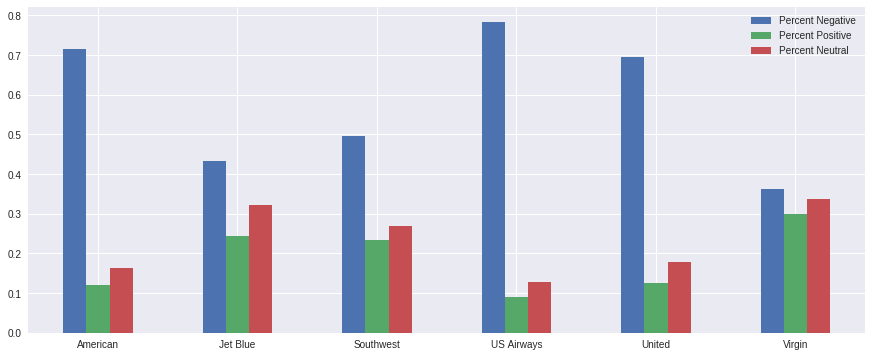

In [26]:
ax = merged_perc.plot(kind = 'bar', rot = 0, figsize = (15,6))
plt.show()

We now have accurate data, and a clear picture of which airline just really upset people. US Airways, no wonder why you were acquired by American Airlines a year later. A lot of people were not happy for you. By why weren't they happy with you? Let's extract all the reasons why people were upset and aggregate them for each airline while plotting the results. 

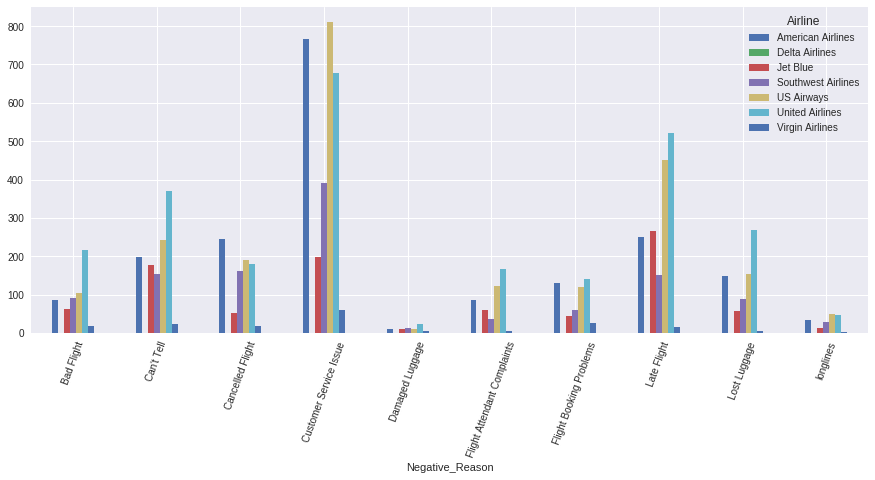

In [27]:
#function that reduces the dataframe to only the airline and the negative reasons, then extract the reasons and the frequency
#each reason was referenced to an airline
def reason(df):
    df = df.reset_index().loc[:,['Airline','Negative_Reason']].dropna().groupby(['Airline','Negative_Reason']).size()
    return df

#call the function and plot the results
ax1 = reason(conf_df).unstack(0).plot(kind = 'bar', figsize = (15,6), rot = 70)

plt.show()

Let's see how the negative tweets break down for each day of the data. It appears that we have about a weeks worth of tweet data here, so let's sort out only the negatives and see how much an airline got hated on each day

In [28]:
print(conf_df.Date.min())
print(conf_df.Date.max())

2015-02-17
2015-02-24


In [35]:
#groupby by Date first making it the main index, then group by the airline, then finally the rating and see how many
#of each rating an airline got for each date
day_df = conf_df.groupby(['Date','Airline','Rating']).size()
day_df

Date        Airline             Rating  
2015-02-17  Jet Blue            negative     51
                                neutral      60
                                positive     47
            Southwest Airlines  negative    161
                                neutral      66
                                positive     55
            US Airways          negative    155
                                neutral      22
                                positive     32
            United Airlines     negative    172
                                neutral      49
                                positive     29
            Virgin Airlines     negative      9
                                neutral      15
                                positive     15
2015-02-18  Jet Blue            negative    127
                                neutral      80
                                positive     77
            Southwest Airlines  negative    142
                                neutral      93

We want to filter this down to just the negative counts for each airline. A neat little trick to conver this output into just another dataframe is simply by resetting the index

In [36]:
day_df = day_df.reset_index()
day_df.head()

,Date,Airline,Rating,0
0,2015-02-17,Jet Blue,negative,51
1,2015-02-17,Jet Blue,neutral,60
2,2015-02-17,Jet Blue,positive,47
3,2015-02-17,Southwest Airlines,negative,161
4,2015-02-17,Southwest Airlines,neutral,66


Next, we want to rename that '0' column to something more informational, like 'Count'. Also we can use boolean logic to filter the dataframe down to only 'negative' ratings

In [37]:
#rename the column
day_df = day_df.rename(columns = {0:'Count'})
#filter to only negative ratings
day_df = day_df[day_df.Rating == 'negative'].reset_index()
#Remove delta since it only has 2 entries
day_df = day_df[day_df.Airline != 'Delta Airlines']
day_df.head()

,index,Date,Airline,Rating,Count
0,0,2015-02-17,Jet Blue,negative,51
1,3,2015-02-17,Southwest Airlines,negative,161
2,6,2015-02-17,US Airways,negative,155
3,9,2015-02-17,United Airlines,negative,172
4,12,2015-02-17,Virgin Airlines,negative,9


We have an extra column in there that we don't really are about, so we can slice that out, and then regroup our new dataframe again using 'Date' as the main index and 'Airline' as the secondary index. From there, we can simply plot our results

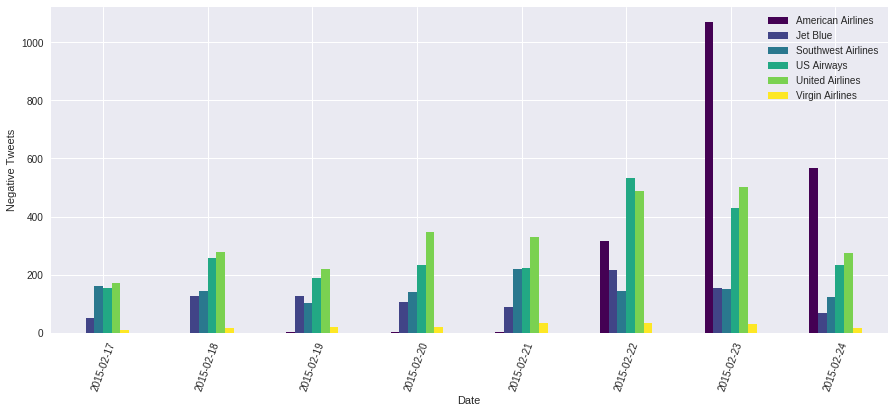

In [38]:
#slice out the first 2 columns of the resultant dataframe
day_df = day_df.iloc[:,1:5]

#groupby and plot data
ax2 = day_df.groupby(['Date','Airline']).sum().unstack().plot(kind = 'bar', colormap = 'viridis', figsize = (15,6), rot = 70)
labels = ['American Airlines','Jet Blue','Southwest Airlines','US Airways','United Airlines','Virgin Airlines']
ax2.legend(labels = labels)
ax2.set_xlabel('Date')
ax2.set_ylabel('Negative Tweets')
plt.show()

I don't know what happend on the 23, but it looks like all the American Airlines flights decided to revolt against their customers all at once. Wow. Let's take our analysis a step further and see what power twitter really has. Let's compare the amount of complaints per day to the stock prices of these airlines on those days. Unfortunately however, Virgin Airlines is a privately held company so there's no stock info on them. Also US Airways was eventually acquired by American Airlines in a merger shortly after this data. So we can only compile data for the other 4 Airlines. I've already downloaded the historical stock data from Yahoo Finance for American, Jet Blue, Southwest, and United. Let's load the data and see what we get

In [75]:
JB = pd.read_csv('JBLU.csv')
AM = pd.read_csv('American.csv')
SW = pd.read_csv('Southwest.csv')
UN = pd.read_csv('United.csv')
UN.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2015-01-02,67.739998,68.080002,65.709999,66.339996,66.339996,6215000
1,2015-01-05,66.870003,67.349998,65.500000,66.150002,66.150002,5033400
2,2015-01-06,66.629997,67.000000,63.110001,64.580002,64.580002,6051700
3,2015-01-07,64.959999,66.110001,64.000000,65.529999,65.529999,5135000
4,2015-01-08,65.699997,67.519997,65.410004,66.639999,66.639999,6889500


Inspecting the data structure in the **UNITED AIRLINES** stock data, we will probably only need the "Date", "Open", and "Close" data. We also only need the dates that correspond to the same dates as the twitter data. Let's build a function that we can pass all over csv files through to reduce the dataframes to the desired form, and then we will concatentate them. Also we need a way to designate between each airline since all csv files looked exactly the same. So we will add a multiindex column in the dataframe serpating the data by Airlines

In [76]:
def result(df, al = 'JB'):
    #set the column name for the appropriate airline
    if al == 'JB':
        airline = 'Jet Blue'
    elif al =='AM':
        airline = 'American Airlines'
    elif al == 'SW':
        airline = 'Southwest Airlines'
    elif al == 'UN':
        airline = 'United Airlines'
    
    #slice the data frame to only the columns and dates that we want
    df = df.loc[30:36,['Date','Open','Close']]
    df.Date = pd.to_datetime(df['Date'])
    #input the Airline column
    df['Airline'] = airline
    #create the mulitindex column with the airlines
    df = df.set_index(['Date','Airline']).unstack().swaplevel(0,1,1).sort_index(1)
    return df

In [77]:
#Call our function above and clean up our dataframes to the desired output
JB = result(JB, 'JB')
AM = result(AM, 'AM')
SW = result(SW, 'SW')
UN = result(UN, 'UN')

#Concatenate our cleaned up data frames
stocks = pd.concat([JB,AM,SW,UN], axis = 1)
stocks

Airline      Jet Blue            American Airlines             \
                 Open      Close              Open      Close   
Date                                                            
2015-02-17  16.950001  16.820000         48.770000  48.009998   
2015-02-18  16.950001  16.830000         48.599998  49.310001   
2015-02-19  17.209999  17.020000         50.779999  49.779999   
2015-02-20  17.070000  17.490000         49.810001  51.020000   
2015-02-23  17.530001  17.780001         51.750000  51.310001   
2015-02-24  17.750000  18.070000         50.290001  51.520000   
2015-02-25  18.000000  17.530001         51.299999  49.730000   

Airline    Southwest Airlines            United Airlines             
                         Open      Close            Open      Close  
Date                                                                 
2015-02-17          43.459999  42.590000       66.500000  64.930000  
2015-02-18          42.939999  43.549999       65.900002  66.720001  
2015-02-19          44.919998  43.759998       68.449997  66.089996  
2015-02-20          43.650002  44.779999       66.089996  68.010002  
2015-02-23          45.110001  44.689999       69.029999  68.839996  
2015-02-24          44.380001  45.349998       67.949997  70.889999  
2015-02-25          45.020000  44.119999       70.559998  68.690002

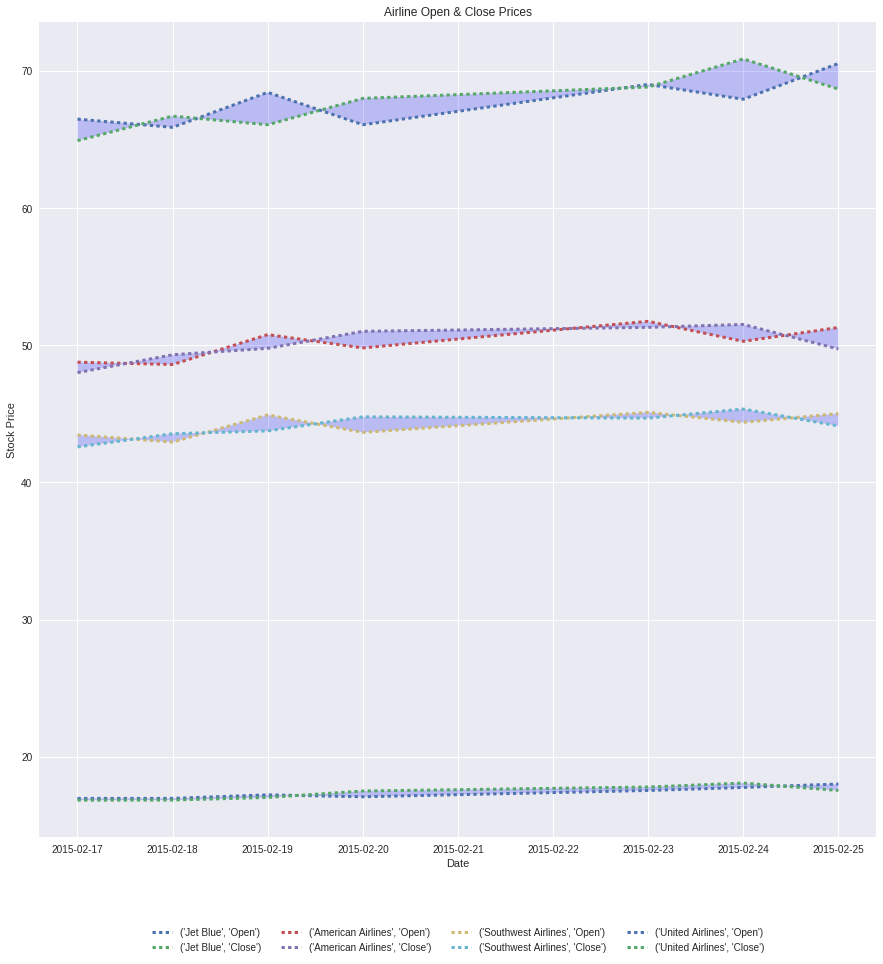

In [119]:
fig, ax3 = plt.subplots(figsize = (15,15))
#ax3 = stocks.plot(figsize = (15,6) )

ax3.fill_between(stocks.index,stocks.iloc[:,0],stocks.iloc[:,1],
                facecolor='blue', alpha=0.2, interpolate=True)
ax3.fill_between(stocks.index,stocks.iloc[:,2],stocks.iloc[:,3],
                facecolor='blue', alpha=0.2, interpolate=True)
ax3.fill_between(stocks.index,stocks.iloc[:,4],stocks.iloc[:,5],
                facecolor='blue', alpha=0.2, interpolate=True)
ax3.fill_between(stocks.index,stocks.iloc[:,6],stocks.iloc[:,7],
                facecolor='blue', alpha=0.2, interpolate=True)
for i in range(len(stocks.columns)): ax3.plot(stocks.iloc[:,i], lw = 3, linestyle = ':') 
ax3.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),fancybox=True, shadow=True, ncol=4)  
ax3.set_xlabel('Date')
ax3.set_ylabel('Stock Price')
ax3.set_title('Airline Open & Close Prices')
plt.show()

Just from first initial impressions, there doesn't appear to be anything significant with this data that would correlate to the twitter data. It might be a waste of time continuing down this avenue. But this is fine. We at least explored the possibility of a correlation. However, I think it's pretty clear that we at all costs should avoid US Airways. Their ratings as told by the people is just terrible. They have a real bad Customer Service Department, and their flights are apparently always late.

### SUMMARY: AVOID US AIRWAYS
Overall it appears that Virgin Airlines would be the best choice, but be careful of this decisions. Virgin was the least talked about Airline in the Twitter-verse, but just because people aren't talking about you doesn't mean they like you either! But let's roll the dice and fly with Sir Richard Branson